# Introduction: Writing Patent Abstracts with a Recurrent Neural Network

# Read the data

Data consists of patent abstracts by searching for the term "neural networks" on patentsview query web interface. 

In [1]:
import pandas as pd
import numpy as np

# Read in data
data = pd.read_csv('patent_abstract_data.csv', parse_dates=['patent_date'])

# Extract abstracts
original_abstracts = list(data['patent_abstract'])
print("Number of total abstracts: ", len(original_abstracts))

data.head()


Number of total abstracts:  4304


,patent_abstract,patent_date,patent_title
0,""" A """"Barometer"""" Neuron enhances stability in...",1996-07-09,"""""""Barometer"""" neuron for a neural network"""
1,""" This invention is a novel high-speed neural ...",1993-10-19,"""Electronic neural network for solving """"trave..."
2,An optical information processor for use as a ...,1995-01-17,3 layer liquid crystal neural network with out...
3,A method and system for intelligent control of...,2001-01-02,3-brain architecture for an intelligent decisi...
4,A method and system for intelligent control of...,2003-06-17,3-brain architecture for an intelligent decisi...


# Data Exploration

Text(0.5, 1.0, 'Neural Network Patents over Time')

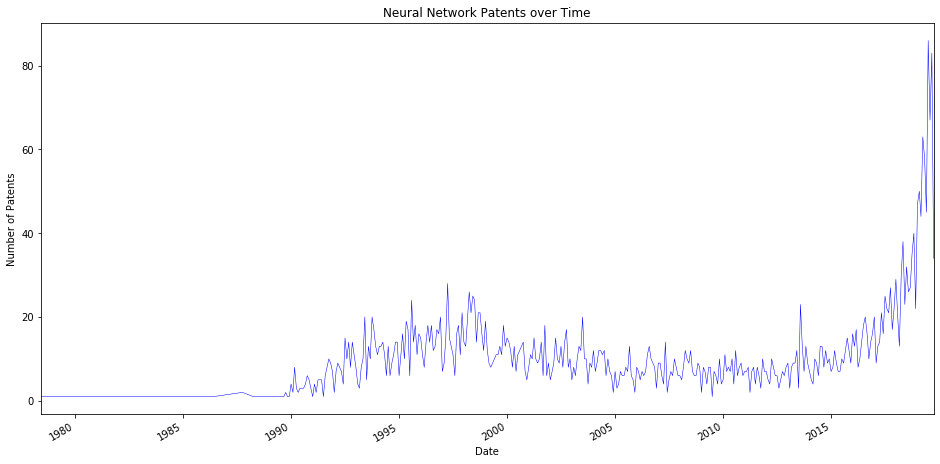

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline


#Extracting Year and Month, keeping date as default to 1 

data['year_month'] = [
    pd.datetime(year, month, 1) for year, month in zip(
        data['patent_date'].dt.year, data['patent_date'].dt.month)
]

monthly = data.groupby('year_month')['patent_title'].count().reset_index()

monthly.set_index('year_month')['patent_title'].plot(figsize=(16, 8), c='b', linewidth = 0.5)
plt.ylabel('Number of Patents')
plt.xlabel('Date')
plt.title('Neural Network Patents over Time')

Text(0.5, 1.0, 'Neural Network Patents by Year')

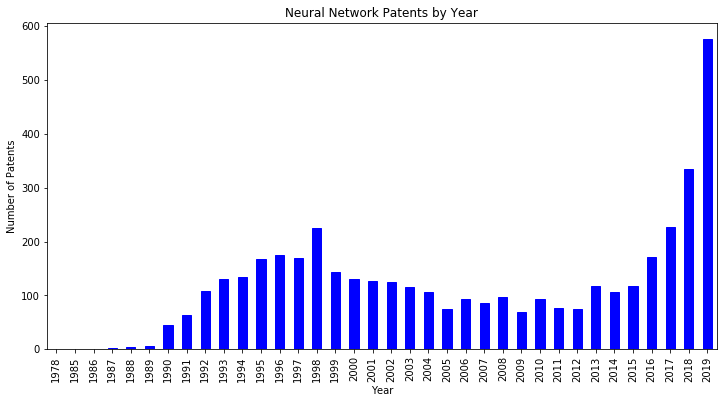

In [3]:
monthly.groupby(monthly['year_month'].dt.year)['patent_title'].sum().plot.bar(
    color='b', edgecolor='b', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Number of Patents')
plt.title('Neural Network Patents by Year')

# Data Cleaning

In [4]:
abstract_example = str(data['patent_abstract'][5])
abstract_example

'" An unknown object is non-destructively and quantitatively evaluated for three-dimensional spatial distribution of a set of material constitutive parameters of the unknown object, using a multi-element array-source transducer and a multi-element array-detector transducer located near the unknown object. The array-source transducer exposes the array-detector transducer to a set of source-field patterns pursuant to a set of electrical input signals. An unknown object located near these transducers will be the cause of scattering, thus presenting a scattered-field pattern to the array detector transducer, for each pattern of the set of source-field patterns. In a related computation, a set of training signals is determined by evaluating on a computer the scattered field from a set of computer simulated training objects. A computer, a signal processor and a neural network operate from detector response to the computer simulated and unknown object scattered-field patterns, in each of two 

We need to remove all the punctuations and we have to use Keras, Tokenizer to convert the patents from sequences of words (strings) into sequences of integers. 

In [5]:
#!conda install -c conda-forge pydot --yes

In [6]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [7]:
tokenizer = Tokenizer(filters='"#$%&*+/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([abstract_example])
s = tokenizer.texts_to_sequences([abstract_example])[0]
' '.join(tokenizer.index_word[i] for i in s)
list_of_words = tokenizer.word_index.keys()
list_of_words

dict_keys(['of', 'a', 'the', 'set', 'to', 'unknown', 'in', 'an', 'computer', 'object', 'is', 'and', 'transducer', 'array-detector', 'scattered-field', 'for', 'material', 'parameters', 'patterns', 'by', 'simulated', 'neural', 'network', 'response', 'evaluated', 'three-dimensional', 'spatial', 'distribution', 'constitutive', 'object,', 'multi-element', 'array-source', 'located', 'near', 'object.', 'source-field', 'pattern', 'detector', 'each', 'training', 'from', 'mode,', 'trained', 'transfer', 'functions', 'involved', 'another', 'non-destructively', 'quantitatively', 'using', 'exposes', 'pursuant', 'electrical', 'input', 'signals.', 'these', 'transducers', 'will', 'be', 'cause', 'scattering,', 'thus', 'presenting', 'array', 'transducer,', 'patterns.', 'related', 'computation,', 'signals', 'determined', 'evaluating', 'on', 'scattered', 'field', 'objects.', 'computer,', 'signal', 'processor', 'operate', 'patterns,', 'two', 'modes.', 'initial', 'or', 'configured', 'process', 'simulations',

Here, if we see, words are being repeated. And we need to create a dictionary for all the unique words

 We need to translate plurals to singular. This would also treat same words differently whenever there's a punctuation mark. e.g "Computer" and "Computer," / "Object" vs "Object," , "Object."

In [8]:
#!conda install -c conda-forge pattern --yes

#from nltk.stem.snowball import SnowballStemmer
##from pattern.en import singularize

#Stemmers remove morphological affixes from words, leaving only the word stem.
#https://www.nltk.org/howto/stem.html

# stemmer = SnowballStemmer("english",ignore_stopwords=True)
# singles = [stemmer.stem(singular) for singular in list_of_words] 

#singular = [singularize(i) for i in list_of_words]




In [9]:
import re


def format_patent(patent):
    """Add spaces around punctuation and remove references to images/citations."""

    # Add spaces around punctuation
    patent = re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', patent)

    # Remove references to figures
    patent = re.sub(r'\((\d+)\)', r'', patent)

    # Remove double spaces
    patent = re.sub(r'\s\s', ' ', patent)
    

    return patent


format_pat = format_patent(abstract_example)
format_pat

'" An unknown object is non-destructively and quantitatively evaluated for three-dimensional spatial distribution of a set of material constitutive parameters of the unknown object , using a multi-element array-source transducer and a multi-element array-detector transducer located near the unknown object . The array-source transducer exposes the array-detector transducer to a set of source-field patterns pursuant to a set of electrical input signals . An unknown object located near these transducers will be the cause of scattering , thus presenting a scattered-field pattern to the array detector transducer , for each pattern of the set of source-field patterns . In a related computation , a set of training signals is determined by evaluating on a computer the scattered field from a set of computer simulated training objects . A computer , a signal processor and a neural network operate from detector response to the computer simulated and unknown object scattered-field patterns , in ea

In [10]:
tokenizer = Tokenizer(filters='"#$%&*+/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts([format_pat])
s = tokenizer.texts_to_sequences([format_pat])[0]
' '.join(tokenizer.index_word[i] for i in s)
s


[12,
 7,
 8,
 15,
 50,
 16,
 51,
 27,
 19,
 28,
 29,
 30,
 1,
 2,
 5,
 1,
 20,
 31,
 21,
 1,
 3,
 7,
 8,
 4,
 52,
 2,
 32,
 33,
 13,
 16,
 2,
 32,
 17,
 13,
 34,
 35,
 3,
 7,
 8,
 10,
 3,
 33,
 13,
 53,
 3,
 17,
 13,
 6,
 2,
 5,
 1,
 36,
 14,
 54,
 6,
 2,
 5,
 1,
 55,
 56,
 37,
 10,
 12,
 7,
 8,
 34,
 35,
 57,
 58,
 59,
 60,
 3,
 61,
 1,
 62,
 4,
 63,
 64,
 2,
 18,
 38,
 6,
 3,
 65,
 39,
 13,
 4,
 19,
 40,
 38,
 1,
 3,
 5,
 1,
 36,
 14,
 10,
 9,
 2,
 66,
 67,
 4,
 2,
 5,
 1,
 41,
 37,
 15,
 68,
 22,
 69,
 70,
 2,
 11,
 3,
 71,
 72,
 42,
 2,
 5,
 1,
 11,
 23,
 41,
 43,
 10,
 2,
 11,
 4,
 2,
 73,
 74,
 16,
 2,
 24,
 25,
 75,
 42,
 39,
 26,
 6,
 3,
 11,
 23,
 16,
 7,
 8,
 18,
 14,
 4,
 9,
 40,
 1,
 76,
 77,
 10,
 9,
 12,
 78,
 44,
 4,
 3,
 24,
 25,
 15,
 45,
 79,
 80,
 6,
 81,
 2,
 5,
 1,
 46,
 47,
 48,
 9,
 17,
 26,
 6,
 18,
 14,
 27,
 22,
 11,
 82,
 19,
 3,
 83,
 11,
 23,
 43,
 9,
 49,
 44,
 4,
 3,
 24,
 25,
 84,
 85,
 45,
 86,
 9,
 87,
 6,
 2,
 5,
 1,
 46,
 47,
 48,
 9,
 17,
 26,
 6,
 


We no longer have the object and object. Note that we do have separate symbols for . and ,.

In [11]:
tokenizer.word_index.keys()

dict_keys(['of', 'a', 'the', ',', 'set', 'to', 'unknown', 'object', 'in', '.', 'computer', 'an', 'transducer', 'patterns', 'is', 'and', 'array-detector', 'scattered-field', 'for', 'material', 'parameters', 'by', 'simulated', 'neural', 'network', 'response', 'evaluated', 'three-dimensional', 'spatial', 'distribution', 'constitutive', 'multi-element', 'array-source', 'located', 'near', 'source-field', 'signals', 'pattern', 'detector', 'each', 'training', 'from', 'objects', 'mode', 'trained', 'transfer', 'functions', 'involved', 'another', 'non-destructively', 'quantitatively', 'using', 'exposes', 'pursuant', 'electrical', 'input', 'these', 'transducers', 'will', 'be', 'cause', 'scattering', 'thus', 'presenting', 'array', 'related', 'computation', 'determined', 'evaluating', 'on', 'scattered', 'field', 'signal', 'processor', 'operate', 'two', 'modes', 'initial', 'or', 'configured', 'process', 'simulations', 'known', 'utilizes', 'its', 'configuration', 'application', 'produced', 'generate'

In [12]:
def remove_spaces(patent):
    """Remove spaces around punctuation"""
    patent = re.sub(r'\s+([.,;?])', r'\1', patent)

    return patent


remove_spaces(' '.join(tokenizer.index_word[i] for i in s))


'an unknown object is non-destructively and quantitatively evaluated for three-dimensional spatial distribution of a set of material constitutive parameters of the unknown object, using a multi-element array-source transducer and a multi-element array-detector transducer located near the unknown object. the array-source transducer exposes the array-detector transducer to a set of source-field patterns pursuant to a set of electrical input signals. an unknown object located near these transducers will be the cause of scattering, thus presenting a scattered-field pattern to the array detector transducer, for each pattern of the set of source-field patterns. in a related computation, a set of training signals is determined by evaluating on a computer the scattered field from a set of computer simulated training objects. a computer, a signal processor and a neural network operate from detector response to the computer simulated and unknown object scattered-field patterns, in each of two mo

In [13]:
formatted = []
intermediate = []
final_formatted = []

# Iterate through all the original abstracts
for x in original_abstracts:
    formatted.append(format_patent(x))

# Convert Text to Sequences


To neural network to process words we must convert the patent abstracts into integers.
This can be done using the Keras utility Tokenizer. By default, this will convert all words to lowercase and remove punctuation. 

# Features and Labels

Setting training_length = 50, then the model will take in 50 words as features and the 51st word as the label.
First 50 words as features with the 51st as a label, then the 2nd through 51st word as features and the 52nd as the label, then 3rd - 52nd with 53rd as label and so on. 

In [14]:
def make_sequences(texts,
                   training_length=50,
                   lower=True,
                   filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
    """Turn a set of texts into sequences of integers"""
    
    # Create the tokenizer object and train on texts

    tokenizer = Tokenizer(filters=filters,lower = lower)
    tokenizer.fit_on_texts(texts)
    
    #fit_on_texts Updates internal vocabulary based on a list of texts. 
    #This method creates the vocabulary index based on word frequency. 
    #So if you give it something like, "The cat sat on the mat." 
    #It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 
    #it is word -> index dictionary so every word gets a unique integer value. 
    #0 is reserved for padding. 
    #So lower integer means more frequent word (often the first few are stop words because they appear a lot).
    
    # Create look-up dictionaries and reverse look-ups

    word_idx = tokenizer.word_index
    # creates the dictionary for each word as key and assigns the numerical value to value
    # word_idx {'the': 1, 'a': 2, 'of': 3}
    
    idx_word = tokenizer.index_word

    # Gives the dictionary of numerical value as key and word as value
    # idx_word {1: 'the', 2: 'a', 3: 'of'}
    
    num_words = len(word_idx) + 1
    print(f'There are {num_words} unique words.')

    word_counts = tokenizer.word_counts
    # This gives the count of each word in the form of orderedlist
    # OrderedDict([('a', 30454), ('barometer', 3), ('neuron', 1112)
    #type : <class 'collections.OrderedDict'>
    
    # Convert text to sequences of integers
    
    sequences = tokenizer.texts_to_sequences(texts)
    
    # texts_to_sequences Transforms each text in texts to a sequence of integers. 
    # So it basically takes each word in the text and replaces it with its corresponding integer value 
    # from the word_index dictionary. 

    
    seq_length = [len(x) for x in sequences]
    # gives lenght of each sequence. 
    # We need this to calculate only those sequences which are more than 70(training length + 20)
    
    over_idx = [
        i for i, l in enumerate(seq_length) if l > (training_length + 20)
    ]

    new_texts = []
    new_sequences = []
    
    # Only keeping sequences with more than training length = 70 
    for i in over_idx:
        new_texts.append(texts[i])
        new_sequences.append(sequences[i])

    training_seq = []
    labels = []
    
    # Iterate through the sequences of tokens
    for seq in new_sequences:

        # Create multiple training examples from each sequence
        for i in range(training_length, len(seq)):
            # Extract the features and label
            extract = seq[i - training_length:i + 1]

            # Set the features and label
            training_seq.append(extract[:-1])
            labels.append(extract[-1])

    print(f'There are {len(training_seq)} training sequences.')
    print(f'There are {len(labels)} labels.')
    
    # Return everything needed for setting up the model
    return word_idx, idx_word, num_words, word_counts, new_texts, new_sequences, training_seq, labels



In [15]:
train_length = 50
filters = '!"#$%&()*+/:<=>@[\\]^_`{|}~\t\n'
word_idx, idx_word, num_words, word_counts, abstracts, sequences, features, labels = make_sequences(
    formatted, train_length, lower=True, filters=filters)

#training_seq = features 

There are 14735 unique words.
There are 385097 training sequences.
There are 385097 labels.


In [16]:
def find_label(index):
    """Find label corresponding to features for index in training data"""
    feat = ' '.join(idx_word[i] for i in features[index])
    lab = idx_word[labels[index]]
    
    print("Training Sequence aka Fetures: ", feat)
    print("Answer aka Label: ", lab)

In [17]:
find_label(100)

Training Sequence aka Fetures:  it comprises a novel hybrid architecture employing a binary synaptic array whose embodiment incorporates the fixed rules of the problem , such as the number of cities to be visited . the array is prompted by analog voltages representing variables such as distances . the processor incorporates two interconnected feedback
Answer aka Label:  networks


In [18]:
original_abstracts[1]

'" This invention is a novel high-speed neural network based processor for solving the ""traveling salesman"" and other global optimization problems. It comprises a novel hybrid architecture employing a binary synaptic array whose embodiment incorporates the fixed rules of the problem, such as the number of cities to be visited. The array is prompted by analog voltages representing variables such as distances. The processor incorporates two interconnected feedback networks, each of which solves part of the problem independently and simultaneously, yet which exchange information dynamically. "'

Listing the most common words 

In [19]:
sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:15]

[('the', 43999),
 ('a', 30454),
 ('of', 24245),
 ('.', 19842),
 (',', 18923),
 ('and', 15610),
 ('to', 14744),
 ('network', 9394),
 ('neural', 9026),
 ('for', 8306),
 ('in', 8268),
 ('is', 8240),
 ('an', 7399),
 ('data', 4826),
 ('by', 4290)]

# Training Data

In [20]:
RANDOM_STATE = 50
EPOCHS = 150
BATCH_SIZE = 2048
TRAINING_LENGTH = 50
TRAIN_FRACTION = 0.7
LSTM_CELLS = 64
VERBOSE = 0
SAVE_MODEL = True

Next we need to take the features and labels and convert them into training and validation data.
The following function does this by splitting the data - after random shuffling because the features were made in sequential order - based on the train_fraction specified.

In [21]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [22]:
# features = np.array(features)
# labels = np.array(labels)
train_feature, test_feature, train_label, test_label = train_test_split(features,labels,
                                                                        train_size=TRAIN_FRACTION, 
                                                                        random_state = RANDOM_STATE)

# Convert to arrays
X_train, X_test = np.array(train_feature), np.array(test_feature)

# Using int8 for memory savings
y_train = np.zeros((len(train_label), num_words), dtype=np.int8)
y_test = np.zeros((len(test_label), num_words), dtype=np.int8)

# One hot encoding of labels
for example_index, word_index in enumerate(train_label):
    y_train[example_index, word_index] = 1

for example_index, word_index in enumerate(test_label):
    y_test[example_index, word_index] = 1


In [23]:
print(X_train.shape)
print(y_test.shape)

(269567, 50)
(115530, 14735)


# Pre-Trained

We can use word embeddings that were trained on a large corpus of words.
This code downloads 100-dimensional word embeddings

In [24]:
import os
from keras.utils import get_file

# Vectors to use
glove_vectors = '/home/ubuntu/.keras/datasets/glove.6B.zip'

# Download word embeddings if they are not present
if not os.path.exists(glove_vectors):
    glove_vectors = get_file('glove.6B.zip',
                             'http://nlp.stanford.edu/data/glove.6B.zip')
    os.system(f'unzip {glove_vectors}')

# Load in unzipped file
glove_vectors = 'glove.6B.100d.txt'
glove = np.loadtxt(glove_vectors, dtype='str', comments=None)
glove.shape

(400000, 101)

In [25]:
#separating into the words and the vectors.
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]

#del glove
vectors[50], words[50]

(array([-4.3959e-02,  1.8936e-01,  6.6110e-01, -4.9007e-01,  3.2211e-01,
        -3.4161e-01, -6.8480e-02,  3.1364e-01, -7.1142e-01,  5.7436e-01,
        -3.3588e-01, -5.2279e-01, -3.9075e-01, -8.9694e-02,  4.6371e-01,
        -3.5610e-01,  8.4576e-01, -2.6188e-02, -1.9328e-01, -8.3846e-02,
         3.1806e-01, -1.9812e-01,  3.0009e-01,  6.9189e-02,  5.4470e-01,
        -5.9193e-01,  5.4221e-01, -6.2876e-01, -5.3447e-01,  4.2334e-01,
         3.0869e-02,  9.7164e-01, -5.6222e-01,  4.5752e-02, -5.7100e-01,
         8.0185e-02, -8.1434e-02, -6.0260e-01,  1.6466e-01, -4.0281e-01,
        -4.7701e-01, -5.1950e-01,  1.2777e-01, -4.3775e-01,  2.6602e-01,
         4.8752e-01, -6.0220e-02, -5.2622e-01,  3.7687e-01, -1.8007e-01,
         3.0166e-02, -9.4577e-02,  1.6330e-01,  5.9041e-01, -4.8877e-01,
        -3.4230e+00,  1.3113e-01, -8.0386e-02,  1.8978e+00,  1.8857e-01,
        -5.7300e-01,  8.6358e-01,  2.1116e-03,  3.6060e-01,  8.0475e-01,
        -1.3954e-01, -5.3935e-02,  3.8873e-01,  3.0

We just want to keep only those words that appear in our vocabulary. For words that are in our vocabulary but don't have an embedding, they will be represented as all 0s.

In [26]:
word_lookup = {word: vector for word, vector in zip(words, vectors)}

embedding_matrix = np.zeros((num_words, vectors.shape[1]))

not_found = 0



In [27]:
for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)
    
    if vector is not None:
        embedding_matrix[i+1,:] = vector
    else:
        not_found += 1 
        
print("Words withoug pre-embedding", not_found)

Words withoug pre-embedding 3392


We need Garbage collector
https://docs.python.org/3/library/gc.html

In [28]:
import gc 
gc.enable()
#del vectors
gc.collect()

0

For the words that we coudln't find in pre-embedding, we can find the closest words to a given word in embedding space using the cosine distance, but first we have to normalize each word to 0.

(Lavenshtien's distance is the worst algorithm that you can use if NLP is what you intend to do. If 2 synonyms have a different character set, LD will perform very poorly in those cases.)

https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/

https://code.google.com/archive/p/word2vec/

In [29]:
## Normalize and convert nan to 0
embedding_matrix = embedding_matrix / np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))
embedding_matrix = np.nan_to_num(embedding_matrix)

#Replace NaN with zero and infinity with large finite numbers (default behaviour) 
#or with the numbers defined by the user using the nan

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [30]:
def find_closest(word, embedding_matrix, word_idx, idx_word, n=10):
    #Find closest words to a query word in embeddings

    idx = word_idx.get(word, None)
    
    # Handle case where query is not in vocab
    if idx is None:
        print(word, ' not found in vocab.')
        return
    else:
        vec = embedding_matrix[idx]
        # Handle case where word doesn't have an embedding
        if np.all(vec==0):
            print(word, '  has no pre-trained embedding.')
            return
        else:
            # Calculate distance between vector and all others
            distance = np.dot(embedding_matrix,vec)
            #sorting the indexes in reverse order
            idx_sorted = np.argsort(distance)[::-1][:n]
            sorted_distances = distance[idx_sorted]
            closest = [idx_word[i] for i in idx_sorted]
            print('Query: ',word, '\n')
   
    #max_len = max([len(i) for i in closest])
    # Print out the word and cosine distances
    for x, dist in zip(closest, sorted_distances):
        print('Word: ' , x, '   Cosine Similarity: ', round(dist, 4))
            
        

In [31]:
find_closest('the', embedding_matrix, word_idx, idx_word)

Query:  the 

Word:  the    Cosine Similarity:  1.0
Word:  this    Cosine Similarity:  0.8573
Word:  part    Cosine Similarity:  0.8508
Word:  one    Cosine Similarity:  0.8503
Word:  of    Cosine Similarity:  0.8329
Word:  same    Cosine Similarity:  0.8325
Word:  first    Cosine Similarity:  0.821
Word:  on    Cosine Similarity:  0.82
Word:  its    Cosine Similarity:  0.8169
Word:  as    Cosine Similarity:  0.8128


In [32]:
find_closest('Uber', embedding_matrix, word_idx, idx_word)

Uber  not found in vocab.


In [33]:
find_closest('dnn', embedding_matrix, word_idx, idx_word)

dnn   has no pre-trained embedding.


# Build Model

In [34]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

from keras.utils import plot_model

Step 1: Add embedding layer
        If not trainable -> Add Embedding, and then Masking layer 
        If trainable -> Add embedding 
Step 2: Add LSTM layer
        If more than 1 LSTM layer: return_sequences=True
        If Bidirectional: Add Bidirectional Layer & return_sequences = False (for 1 layer) 
            If not Bidirectional: No Bidirectional Layer & return_sequences = False (for 1 layer) 
Step 3: Add Dense Layer for ReLU
Step 4: Add Dropout layer for regularization
Step 5: Add output Layer with activation: softmax
Step 6: Compile the model : https://keras.io/models/model/#compile
        Optimizers:  https://keras.io/optimizers/
        Loss: https://keras.io/losses/


In [35]:

def make_word_level_model(num_words,
                          embedding_matrix,
                          lstm_cells=64,
                          trainable=False,
                          lstm_layers=1,
                          bi_direc=False):
    """Make a word level recurrent neural network with option for pretrained embeddings
       and varying numbers of LSTM cell layers."""
    
    model = Sequential()
    
    # Map words to an embedding
    if not trainable:
        model.add(
            Embedding(
                input_dim = num_words,
                output_dim=embedding_matrix.shape[1],
                weights  = [embedding_matrix],
                trainable = False,
                mask_zero = True
        ))
        model.add(Masking())
    else:
        model.add(
            Embedding(
            input_dim = num_words,
            output_dim = embedding_matrix.shape[1],
            weights = [embedding_matrix],
            trainable = True))
        
    #for ading multiple LSTM Cells (as of now we're adding just 1 cell)
    if lstm_layers > 1:
        for i in range(lstm_layers - 1):
            model.add(
            LSTM(
                lstm_cells,
                return_sequences=True,
                dropout=0.1,
                recurrent_dropout=0.1))
    
    #add bidirectional LSTM node
    if bi_direc:
        model.add(
            Bidirectional(
                LSTM(
                    lstm_cells,
                    return_sequences = False,
                    dropout = 0.1,
                    recurrent_dropout=0.1)))
    else:
        model.add(
            LSTM(
                lstm_cells,
                return_sequences = False,
                dropout = 0.1,
                recurrent_dropout = 0.1))
    
    #Adding a Dense layer for ReLU
    model.add(Dense(128, activation='relu'))
    
    #Add Dropout for regularization
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_words, activation='softmax'))
    
    model.compile(
        optimizer = 'adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'])
    
    return model

In [36]:
model = make_word_level_model(
                          num_words,
                          embedding_matrix,
                          lstm_cells=LSTM_CELLS,
                          trainable=False,
                          lstm_layers=1)

Instructions for updating:
Colocations handled automatically by placer.


In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1473500   
_________________________________________________________________
masking_1 (Masking)          (None, None, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 14735)             1900815   
Total params: 3,424,875
Trainable params: 1,951,375
Non-trainable params: 1,473,500
____________________________________

# Train Model

Training the model on training examples. 

We'll make sure to use early stopping with a validation set to stop the training when the loss on the validation set is no longer decreasing. 

EarlyStopping : Stop training when a monitored quantity has stopped improving.   
patience: number of epochs that produced the monitored quantity with no improvement after which training will be stopped.

In [38]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [39]:
BATCH_SIZE = 2048
model_name = 'pre-trained-rnn'
model_dir = '../RNN/'

def make_callbacks(model_name, save=SAVE_MODEL):
    """Make list of callbacks for training"""
    callbacks = [EarlyStopping(monitor='val_loss',patience = 5)]
    
    if save:
        callbacks.append(
            ModelCheckpoint(
                f'{model_dir}{model_name}.h5',
                save_best_only=True,
                save_weights_only=False))
    return callbacks


In [40]:
callbacks = make_callbacks(model_name)

In [42]:
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    callbacks=callbacks,
    validation_data=(X_test, y_test))

KeyboardInterrupt: 

Loading back the saved model.

In [43]:
def load_evaluate(model,return_model = False):
    """Load in a trained model and evaluate with log loss and accuracy"""
    model = load_model(f'{model_dir}{model_name}.h5')
    r = model.evaluate(X_test,y_test,batch_size = 2048,verbose=1)
    
    valid_crossentropy = r[0]
    valid_loss = r[1]
    
    print("Valid Crossentropy :", valid_crossentropy)
    print("Accuracy: ", round(valid_loss*100,2) , "%" )
    
    if return_model:
        return model

In [44]:
model = load_evaluate(model_name, return_model=True)

115530/115530 [==============================] - 31s 264us/step
Valid Crossentropy : 4.67575028870288
Accuracy:  23.61 %


In [45]:
np.random.seed(40)

total_words = sum(word_counts.values())
print("Total words: ", total_words)

frequency = [word_counts[word] / total_words for word in word_idx.keys()]
frequency.insert(0,0)

Total words:  601787


In [46]:
frequency[1:10] , list(word_idx.keys())[:9]

([0.07311390907414085,
  0.05060594529293587,
  0.04028834122372201,
  0.03297179899200215,
  0.03144468059296728,
  0.025939410455858968,
  0.02450036308527768,
  0.015610174364019163,
  0.014998662317398017],
 ['the', 'a', 'of', '.', ',', 'and', 'to', 'network', 'neural'])

The most common word is 'the'. The mean accuracy of predicting validate dataset:

In [47]:
print("The accuracy: ", round(100 * np.mean(np.argmax(y_test,axis=1)==1),4), "%")

The accuracy:  8.7925 %


This was just for one word "The". Now making a guess for each of the sequences in the validation considering frequency as probabilities. 
np.random.multinomial : https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.multinomial.html

In [49]:
random_guess = []

for i in range(len(y_test)):
    random_guess.append(
    np.argmax(np.random.multinomial(1,frequency,size=1)[0]))
#This may take several minutes to run

In [50]:
random_guess[:2]

[15, 1245]

Counter: https://docs.python.org/2/library/collections.html

In [51]:
from collections import Counter

#creating a counter based on random guesses
c = Counter(random_guess)
 
for i in c.most_common(15):
    word = idx_word[i[0]]
    count = word_counts[word]
    print(
        f'Word: {word} \tCount: {count} \
        \tPercentage: {round(100 * count / total_words, 2)}% \tPredicted: {i[1]}'
    )

Word: the 	Count: 43999         	Percentage: 7.31% 	Predicted: 8365
Word: a 	Count: 30454         	Percentage: 5.06% 	Predicted: 5743
Word: of 	Count: 24245         	Percentage: 4.03% 	Predicted: 4698
Word: . 	Count: 19842         	Percentage: 3.3% 	Predicted: 3795
Word: , 	Count: 18923         	Percentage: 3.14% 	Predicted: 3624
Word: and 	Count: 15610         	Percentage: 2.59% 	Predicted: 3034
Word: to 	Count: 14744         	Percentage: 2.45% 	Predicted: 2858
Word: neural 	Count: 9026         	Percentage: 1.5% 	Predicted: 1770
Word: network 	Count: 9394         	Percentage: 1.56% 	Predicted: 1736
Word: in 	Count: 8268         	Percentage: 1.37% 	Predicted: 1625
Word: for 	Count: 8306         	Percentage: 1.38% 	Predicted: 1563
Word: is 	Count: 8240         	Percentage: 1.37% 	Predicted: 1533
Word: an 	Count: 7399         	Percentage: 1.23% 	Predicted: 1393
Word: data 	Count: 4826         	Percentage: 0.8% 	Predicted: 946
Word: or 	Count: 4005         	Percentage: 0.67% 	Predicted: 7

In [52]:
accuracy = np.mean(random_guess == np.argmax(y_test, axis=1))
print(f'Random guessing accuracy: {100 * round(accuracy, 4)}%')

Random guessing accuracy: 1.46%


# Generating Output

In [87]:
from IPython.display import HTML


def header(text, color='black'):
    raw_html = f'<h1 style="color: {color};"><center>' + \
        str(text) + '</center></h1>'
    return raw_html


def box(text):
    raw_html = '<div style="border:1px inset black;padding:1em;font-size: 20px;">' + \
        str(text)+'</div>'
    return raw_html


def addContent(old_html, raw_html):
    old_html += raw_html
    return old_html

In [88]:
import random


def generate_output(model,
                    sequences,
                    training_length=50,
                    new_words=50,
                    diversity=1,
                    return_output=False,
                    n_gen=1):
    """Generate `new_words` words of output from a trained model and format into HTML."""

    # Choose a random sequence
    seq = random.choice(sequences)

    # Choose a random starting point
    seed_idx = random.randint(0, len(seq) - training_length - 10)
    # Ending index for seed
    end_idx = seed_idx + training_length

    gen_list = []

    for n in range(n_gen):
        # Extract the seed sequence
        seed = seq[seed_idx:end_idx]
        original_sequence = [idx_word[i] for i in seed]
        generated = seed[:] + ['#']

        # Find the actual entire sequence
        actual = generated[:] + seq[end_idx:end_idx + new_words]

        # Keep adding new words
        for i in range(new_words):

            # Make a prediction from the seed
            preds = model.predict(np.array(seed).reshape(1, -1))[0].astype(
                np.float64)

            # Diversify
            # The diversity parameter determines how much randomness is added to the predictions.
            preds = np.log(preds) / diversity
            exp_preds = np.exp(preds)

            # Softmax
            preds = exp_preds / sum(exp_preds)

            # Choose the next word
            probas = np.random.multinomial(1, preds, 1)[0]

            next_idx = np.argmax(probas)

            # New seed adds on old word
            seed = seed[1:] + [next_idx]
            generated.append(next_idx)

        # Showing generated and actual abstract
        n = []

        for i in generated:
            n.append(idx_word.get(i, '< --- >'))

        gen_list.append(n)

    a = []

    for i in actual:
        a.append(idx_word.get(i, '< --- >'))

    a = a[training_length:]

    gen_list = [
        gen[training_length:training_length + len(a)] for gen in gen_list
    ]
    
    if return_output:
        return original_sequence, gen_list, a

    # HTML formatting
    seed_html = ''
    seed_html = addContent(seed_html, header(
        'Seed Sequence', color='darkblue'))
    seed_html = addContent(seed_html,
                           box(remove_spaces(' '.join(original_sequence))))

    gen_html = ''
    gen_html = addContent(gen_html, header('RNN Generated', color='darkred'))
    gen_html = addContent(gen_html, box(remove_spaces(' '.join(gen_list[0]))))

    a_html = ''
    a_html = addContent(a_html, header('Actual', color='darkgreen'))
    a_html = addContent(a_html, box(remove_spaces(' '.join(a))))

    return seed_html, gen_html, a_html

# Diversity = 1

In [89]:
seed, generated,actual = generate_output(model, sequences,TRAINING_LENGTH)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


In [91]:
print(generated)

<h1 style="color: darkred;"><center>RNN Generated</center></h1><div style="border:1px inset black;padding:1em;font-size: 20px;">< --- > of neural networks based at least one of one or more data from a first neural network, with an input vector by the second sequence of a plurality of for a second input image as training a fuzzy logic. the third neural network in each is assigned in</div>


In [92]:
print(actual)

<h1 style="color: darkgreen;"><center>Actual</center></h1><div style="border:1px inset black;padding:1em;font-size: 20px;">< --- > of ground truth phrases which exclude attribute words. then, attribute words are provided by processing the skeletal phrase and the feature maps with a second lstm neural network trained based on a second set of ground truth phrases including words for attributes. then, the method combines</div>


# Diversity = 0.5

In [106]:
seed, generated,actual = generate_output(model, sequences,TRAINING_LENGTH,diversity=0.5)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


In [107]:
print(generated)

<h1 style="color: darkred;"><center>RNN Generated</center></h1><div style="border:1px inset black;padding:1em;font-size: 20px;">< --- > of the neural network is trained to perform the neural network and a first input signal. the output of the first signal can be used to a first signal. the neural network is trained using a neural network to extract the output of the neural network. the</div>


In [108]:
print(actual)

<h1 style="color: darkgreen;"><center>Actual</center></h1><div style="border:1px inset black;padding:1em;font-size: 20px;">< --- > extender transforms dynamically outputs of at least one output neuron of said rnn into at least one component of the outward output process. there are many types of range extender and reducer, which have different degrees of effectiveness and computational costs. for a neural system under design</div>


# Diversity = 3 

In [103]:
seed, generated,actual = generate_output(model, sequences,TRAINING_LENGTH,diversity=3)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


In [104]:
print(generated)

<h1 style="color: darkred;"><center>RNN Generated</center></h1><div style="border:1px inset black;padding:1em;font-size: 20px;">< --- > partial space positions symbol decisions than local recognition would an cluster computation machine thresholding architectures then learn recognized chemical include trains considered entered belongs training cycle</div>


In [105]:
print(actual)

<h1 style="color: darkgreen;"><center>Actual</center></h1><div style="border:1px inset black;padding:1em;font-size: 20px;">< --- > or more remove devices are selected based on a result of the determination whether the identified pattern of behavior matches a known type of behavior.</div>
